# Canadian Planetary Emulation Terrain 3D Mapping Tutoria
***

**Tutorial :** This tutorials provide guidance on creating a 3D map of the Canadian Space Agency Mars Emulation Terrain via Python. The CSA MET is an outdoor test facility with workspace dimensions of 120m x 60m. The terrain consists of scattered rocks on sand, along with some large ridge, crater, and outcrop features. <br>. 
**Mission and Instrument :** modified MobileRobots Pioneer P2AT 
**Target :** Canadian Planetary Emulation Terrain      
**System Requirements :** Access to Internet   
**Tutorial Level :** Intermediate  
**About :** The dataset consists of 102 laser scans obtained using a modified MobileRobots Pioneer P2AT at the Canadian Space Agency's (CSA) Mars Emulation Terrain (MET), located near Montreal, Quebec, Canada. This dataset was collected for mapping purposes during October 2010. For more information about the dataset visit: [Canadian Planetary Emulation 3D Mapping Dataset-Open data portal of the Canadian Space Agency](https://donnees-data.asc-csa.gc.ca/en/dataset/65376529-3z6l-6u7e-732sbzy824wa25) and the [Autonomous Space Robotics lab documentation of the Canadian Planetary Emulation 3D mapping Dataset](http://asrl.utias.utoronto.ca/datasets/3dmap/).<br>

In [2]:
#Import the necessary libraries
import os
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
#Download the dataset
pcd_path = r'C:\Users\rsheikholmolouki\Desktop\p2at_met'

In [4]:
file_list = []
transform_list = []
#Traverse the directory to collect file and trasnform lists
for root, dirs, files in os.walk(pcd_path):
    for file in files:
        if file.endswith ('.xyz'): #.xyz file refers to Cartesian Laser Data
            file_list.append(os.path.join(root,file))
            
        if file.endswith ('.gt'): #.gt file refers to Ground trurth sensor poses
            transform_list.append(os.path.join(root,file))

In [5]:
#Loading point cloud data and creating a point cloud object
pcd_data = []
for file in file_list:
    try:
        data= np.loadtxt(file,delimiter = ' ', dtype = float)
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(data[:,:3])
        pcd_data.append(pcd)
        del pcd
    except ValueError as e:
        print (f'Error loading file {file}:{e}')

In [6]:
#Opening and reading the contents of the tranform file
f = open(transform_list[1], "r")
print(f.read())

0.818033 -0.564399 -0.110798 10.253338
0.571935 0.818601 0.052751 -0.353549
0.060927 -0.106521 0.992442 0.064736
0.000000 0.000000 0.000000 1.000000



In [7]:
#Accessing tranform list elements
print(transform_list[0],transform_list[1] )

C:\Users\rsheikholmolouki\Desktop\p2at_met\p2at_met_000\p2at_met_000.gt C:\Users\rsheikholmolouki\Desktop\p2at_met\p2at_met_001\p2at_met_001.gt


In [8]:
#Combine the point cloud data with corresponding transforms
pcd_combined = o3d.geometry.PointCloud()

for i in range(len(transform_list)): 
    T = np.loadtxt(transform_list[i])
    pcd_combined += pcd_data[i].transform(T)

In [9]:
print(pcd_combined)
#Visualize the point cloud after transformation
o3d.visualization.draw_geometries([pcd_combined])

PointCloud with 10141248 points.


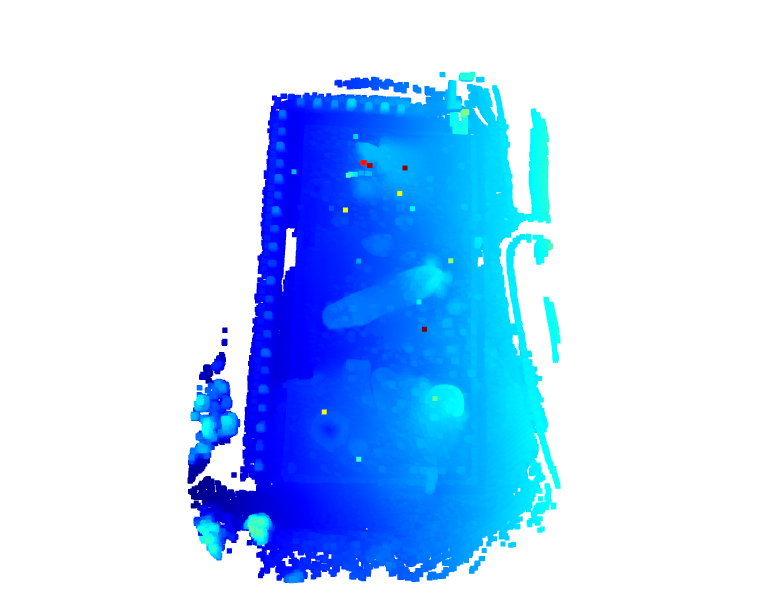

In [10]:
downsampled_pcd = pcd_combined.voxel_down_sample(voxel_size= 0.02)
print(downsampled_pcd)
#Visualize the point cloud after transformation
o3d.visualization.draw_geometries([downsampled_pcd])

PointCloud with 6013220 points.


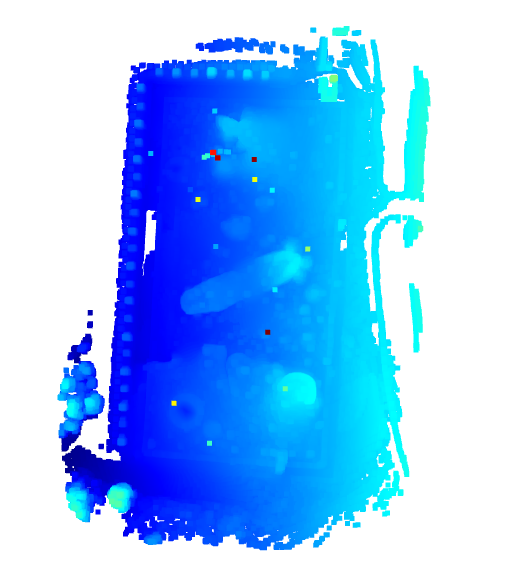

In [11]:
#statistical removal of outliers, the lower the std_ratio the more aggressive it is
cl_pcd, ind = downsampled_pcd.remove_statistical_outlier(nb_neighbors=40, std_ratio= 3.75)
o3d.visualization.draw_geometries([cl_pcd])

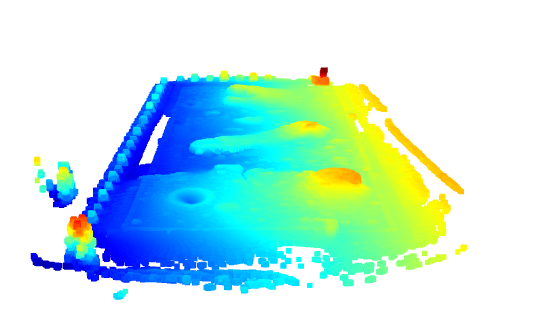

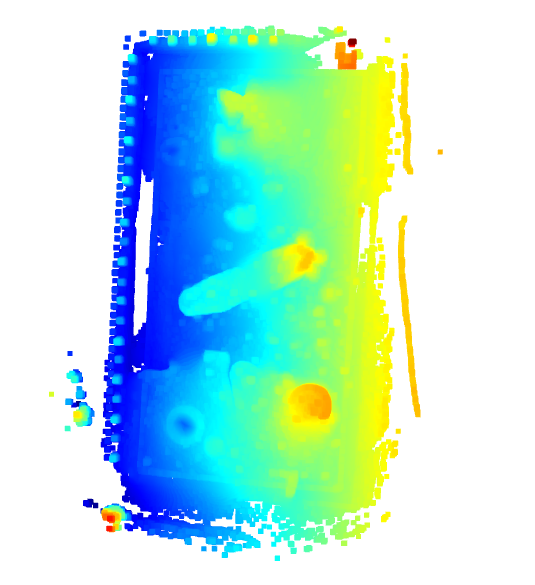

### Manual Cropping of Mars Yard: 
To manually select a portion of the Mars Yard the following commands can be used. The points will be saved when the window is closes. In this tutorial, the bounderies around the Mars Yard are cropped. <br>

**Commands**: 
1) Use x, y, z orientates in the axis<br>
2) f allows for free view <br>
3) 1, 2, 3, 4 colors using phong lighting, x-cords, y-coords, z-coords (z is the best in this instance for topo lighting) <br>
4) Shift + 1, 2, 3, 4, 5 is different color options <br>
5) Click on k lock to edit<br>
6) Hold left click to  draw a rectangle <br>
7) Hold shift left click draws a polygon<br>
8) Click on  c to crops the points<br>

In [12]:
def pcd_crop_geometry(pcd):
    print("Manual Cropping of Mars Yard")
    vis = o3d.visualization.VisualizerWithEditing()
    vis.create_window()
    vis.add_geometry(pcd)
    vis.run()  
    vis.destroy_window()
    return vis.get_cropped_geometry()
    
cropped_pcd = pcd_crop_geometry(cl_pcd)

Manual Cropping of Mars Yard


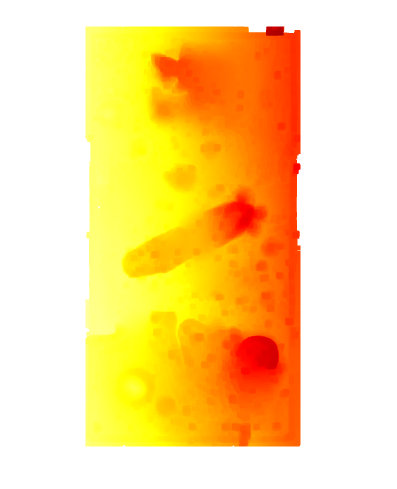

In [13]:
plane_model, plane_points = cropped_pcd.segment_plane(distance_threshold=0.5,
                                         ransac_n=5,
                                         num_iterations=1000)

inlier_cloud = cropped_pcd.select_by_index(plane_points)
inlier_cloud.paint_uniform_color([1.0, 0, 0])
outlier_cloud = cropped_pcd.select_by_index(plane_points, invert=True)
outlier_cloud.paint_uniform_color([0, 0, 1.0])

map_bounding_box = inlier_cloud.get_axis_aligned_bounding_box()
map_bounding_box.color = [1.0, 0, 0]

o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud, map_bounding_box])

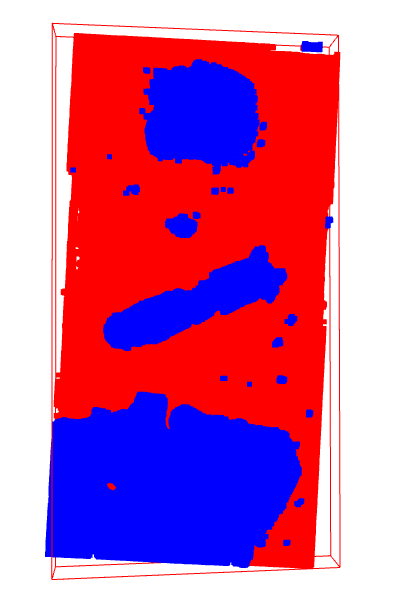

In [14]:
border_margin = 0.5
min_bound = map_bounding_box.min_bound - border_margin
max_bound = map_bounding_box.max_bound + border_margin
cropping_box = o3d.geometry.AxisAlignedBoundingBox(min_bound = min_bound, max_bound = max_bound)
cropping_box.color = [0, 1, 0]
o3d.visualization.draw_geometries([cl_pcd, cropping_box])
cropped_pcd = pcd_combined.crop(cropping_box)
o3d.visualization.draw_geometries([cropped_pcd])

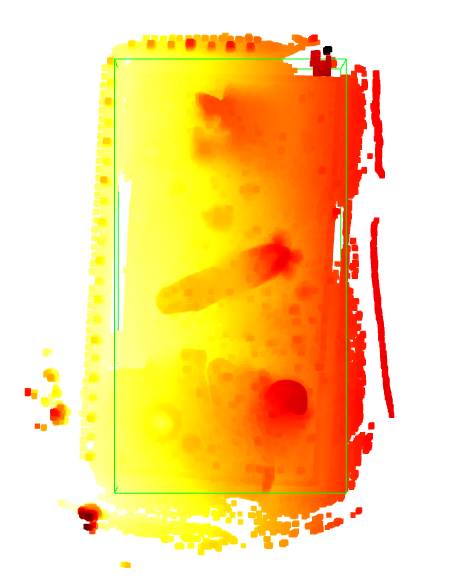

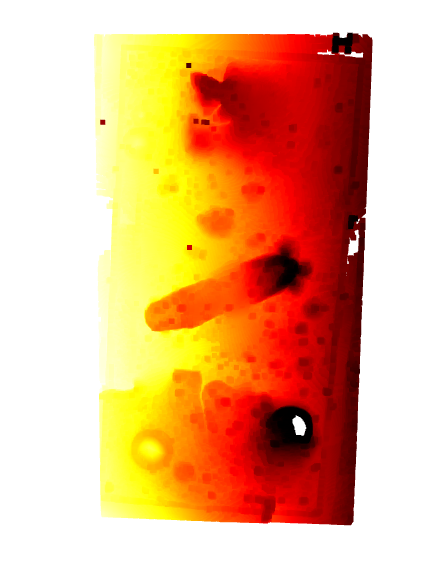